In [1295]:
from pandas import get_dummies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h1>Functions</h1>

In [1296]:
def normalize_and_get_dummies(data):
    data = get_dummies(data)

    #Normalizing the numerical variables
    data['year'] = (data['year'] - 2001)
    data['odometer'] = (data['odometer'] - data['odometer'].min()) / (data['odometer'].max() - data['odometer'].min())
    
    return data

In [1297]:
def remove_categories(data):
    #Creating the size_type feature
    data['size_type'] = data['size']+"-"+data['type']

    #Dropping not used collumns
    data = data.drop(columns=['size', 'cylinders', 'type', 'fuel', 'transmission'])

    return data

In [1298]:
def transformations(data):
    #Do all the transformations
    data = remove_categories(data)
    data = normalize_and_get_dummies(data)
    return data.to_numpy()

In [1299]:
def regression(data, m):
    # Column vector with prices
    d = data[:,0]

    # Data matrix (all features except prices)
    C = data[:, 1:]

    # Get the number of columns
    M = C.shape[1]

    # Get the number of lines
    N = d.shape[0]

    # Create a matrix with N lines and M+2 columns filled with zeros
    # We must have M+2 columns to fit the bias and the year squared
    X = np.ones((N, M+m)) 

    for i in range(1, m+1):
        X[:,i] = (C[:,0])**i
    
    X[:,m+1:] = C[:, 1:] # Put the odometer and the category into the matrix

    # Method showed in class
    R = X.T @ X
    p = X.T @ d
    wo = np.linalg.solve(R,p)
    e = d - X @ wo

    return wo, e

In [1300]:
def prepare_regression(data, m):
    # Column vector with prices
    d = data[:,0]

    # Data matrix (all features except prices)
    C = data[:, 1:]

    # Get the number of columns
    M = C.shape[1]

    # Get the number of lines
    N = d.shape[0]

    # Create a matrix with N lines and M+m columns filled with zeros
    # We must have M+m columns to fit the bias and the year exponent 'm'
    X = np.ones((N, M+m)) 

    for i in range(1, m+1):
        X[:,i] = (C[:,0])**i
    
    X[:,m+1:] = C[:, 1:] # Put the odometer and the categories into the matrix

    return X, d

<h1>Removing selected categorical variables</h1>

<h2>m = 1 (linear model)</h2>

In [1301]:
m=1 # linear year
v_clean = pd.read_csv("./vehicles_cleaned_train.csv")
display(v_clean.head())
v_clean_norm = transformations(v_clean) # Normalize, get dummies and remove some categories

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,10400,2011,excellent,4 cylinders,gas,81300,automatic,mid-size,sedan
1,6900,2007,excellent,6 cylinders,gas,79000,automatic,full-size,sedan
2,18900,2018,like new,4 cylinders,gas,5000,automatic,full-size,sedan
3,6000,2010,excellent,4 cylinders,gas,97600,automatic,mid-size,hatchback
4,19995,2013,good,6 cylinders,gas,95782,automatic,mid-size,sedan


In [1302]:
v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv")
display(v_clean_test.head())
v_clean_norm_test = transformations(v_clean_test) # Normalize, get dummies and remove some categories

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,11995,2018,excellent,4 cylinders,gas,19000,automatic,mid-size,sedan
1,20500,2017,excellent,6 cylinders,gas,68000,automatic,full-size,sedan
2,15800,2018,like new,4 cylinders,gas,41200,automatic,full-size,sedan
3,20980,2015,excellent,6 cylinders,gas,82845,automatic,mid-size,sedan
4,13999,2019,like new,4 cylinders,gas,29638,automatic,full-size,sedan


In [1303]:
# Get the weights and the error using training set
wo, e = regression(v_clean_norm, m)

In [1304]:
# Prepare the data for regression (add 1s and add new columns for powers of years)
# X is the modified data matrix and d is the price column
X, d = prepare_regression(v_clean_norm_test, m)
# Do the prediction
prices_pred = X @ wo

In [1305]:
# Absolute, RMSE and MSE error - Test
abs_error = np.mean(abs(prices_pred - d))
error_squared = np.mean((prices_pred - d)**2)
sqrt_error_test_1 = np.sqrt(error_squared)
print(f"Absolute error: {abs_error}")
print(f"RMSE error: {sqrt_error_test_1}")
print(f"MSE error: {sqrt_error_test_1**2}")

Absolute error: 3733.3212014181036
RMSE error: 5253.531426846155
MSE error: 27599592.4528602


In [1306]:
# Absolute, RMSE and MSE error - Train
abs_e = np.mean(abs(e))
e_squared = np.mean(e**2)
sqrt_error_train_1 = np.sqrt(e_squared)
print(f"Absolute error: {abs_e}")
print(f"RMSE error: {sqrt_error_train_1}")
print(f"MSE error: {sqrt_error_train_1**2}")

Absolute error: 3777.034531724318
RMSE error: 5381.493274350339
MSE error: 28960469.86187793


<h2>m = 2 (year squared)</h2>

In [1307]:
m=2 # The model will use year squared for better prediction, the decision was made using the Exploratory Data Analysis (EDA) 
v_clean = pd.read_csv("./vehicles_cleaned_train.csv")
display(v_clean.head())
v_clean_norm = transformations(v_clean) # Normalize, get dummies and remove some categories

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,10400,2011,excellent,4 cylinders,gas,81300,automatic,mid-size,sedan
1,6900,2007,excellent,6 cylinders,gas,79000,automatic,full-size,sedan
2,18900,2018,like new,4 cylinders,gas,5000,automatic,full-size,sedan
3,6000,2010,excellent,4 cylinders,gas,97600,automatic,mid-size,hatchback
4,19995,2013,good,6 cylinders,gas,95782,automatic,mid-size,sedan


In [1308]:
v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv")
display(v_clean_test.head())
v_clean_norm_test = transformations(v_clean_test) # Normalize, get dummies and remove some categories

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,11995,2018,excellent,4 cylinders,gas,19000,automatic,mid-size,sedan
1,20500,2017,excellent,6 cylinders,gas,68000,automatic,full-size,sedan
2,15800,2018,like new,4 cylinders,gas,41200,automatic,full-size,sedan
3,20980,2015,excellent,6 cylinders,gas,82845,automatic,mid-size,sedan
4,13999,2019,like new,4 cylinders,gas,29638,automatic,full-size,sedan


In [1309]:
# Get the weights and the error using training set
wo, e = regression(v_clean_norm, m)

In [1310]:
# Prepare the data for regression (add 1s and add new columns for powers of years)
# X is the modified data matrix and d is the price column
X, d = prepare_regression(v_clean_norm_test, m)
# Do the prediction
prices_pred = X @ wo

In [1311]:
# Absolute, RMSE and MSE error - Test
abs_error = np.mean(abs(prices_pred - d))
error_squared = np.mean((prices_pred - d)**2)
sqrt_error_test_2 = np.sqrt(error_squared)
print(f"Absolute error: {abs_error}")
print(f"RMSE error: {sqrt_error_test_2}")
print(f"MSE error: {sqrt_error_test_2**2}")

Absolute error: 3701.5094845451918
RMSE error: 5231.2452131562995
MSE error: 27365926.480170697


In [1312]:
# Absolute, RMSE and MSE error - Train
abs_e = np.mean(abs(e))
e_squared = np.mean(e**2)
sqrt_error_train_2 = np.sqrt(e_squared)
print(f"Absolute error: {abs_e}")
print(f"RMSE error: {sqrt_error_train_2}")
print(f"MSE error: {sqrt_error_train_2**2}")

Absolute error: 3737.1565211061516
RMSE error: 5355.2742548481
MSE error: 28678962.344638873


<h1>Using all variables</h1>

<h2>m = 1 (linear model)</h2>

In [1313]:
m=1
v_clean = pd.read_csv("./vehicles_cleaned_train.csv")
display(v_clean.head())
v_clean_norm = normalize_and_get_dummies(v_clean)
v_clean_norm = v_clean_norm.to_numpy()

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,10400,2011,excellent,4 cylinders,gas,81300,automatic,mid-size,sedan
1,6900,2007,excellent,6 cylinders,gas,79000,automatic,full-size,sedan
2,18900,2018,like new,4 cylinders,gas,5000,automatic,full-size,sedan
3,6000,2010,excellent,4 cylinders,gas,97600,automatic,mid-size,hatchback
4,19995,2013,good,6 cylinders,gas,95782,automatic,mid-size,sedan


In [1314]:
# Load test dataset
v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv") 
display(v_clean_test)
v_clean_norm_test = normalize_and_get_dummies(v_clean_test)
v_clean_norm_test = v_clean_norm_test.to_numpy()

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,11995,2018,excellent,4 cylinders,gas,19000,automatic,mid-size,sedan
1,20500,2017,excellent,6 cylinders,gas,68000,automatic,full-size,sedan
2,15800,2018,like new,4 cylinders,gas,41200,automatic,full-size,sedan
3,20980,2015,excellent,6 cylinders,gas,82845,automatic,mid-size,sedan
4,13999,2019,like new,4 cylinders,gas,29638,automatic,full-size,sedan
...,...,...,...,...,...,...,...,...,...
2079,15895,2017,like new,4 cylinders,gas,33734,automatic,mid-size,sedan
2080,14390,2017,excellent,4 cylinders,gas,71219,automatic,mid-size,sedan
2081,17995,2018,like new,4 cylinders,gas,37000,automatic,mid-size,sedan
2082,8900,2011,like new,6 cylinders,gas,45346,automatic,full-size,sedan


In [1315]:
# Get the weights and the error using training set
wo, e = regression(v_clean_norm, m)

In [1316]:
# Prepare the data for regression (add 1s and add new columns for powers of years)
# X is the modified data matrix and d is the price column
X, d = prepare_regression(v_clean_norm_test, m)
# Do the prediction
prices_pred = X @ wo

In [1317]:
# Absolute, RMSE and MSE error - Test
abs_error = np.mean(abs(prices_pred - d))
error_squared = np.mean((prices_pred - d)**2)
sqrt_error_all_test_1 = np.sqrt(error_squared)
print(f"Absolute error: {abs_error}")
print(f"RMSE error: {sqrt_error_all_test_1}")
print(f"MSE error: {sqrt_error_all_test_1**2}")

Absolute error: 3572.6620681319746
RMSE error: 5085.037392940546
MSE error: 25857605.287603583


In [1318]:
# Absolute, RMSE and MSE error - Train
abs_e = np.mean(abs(e))
e_squared = np.mean(e**2)
sqrt_error_all_train_1 = np.sqrt(e_squared)
print(f"Absolute error: {abs_e}")
print(f"RMSE error: {sqrt_error_all_train_1}")
print(f"MSE error: {sqrt_error_all_train_1**2}")

Absolute error: 3660.0172902268982
RMSE error: 5245.880471347568
MSE error: 27519261.919665787


<h2>m = 2 (year squared)</h2>

In [1319]:
m=2
v_clean = pd.read_csv("./vehicles_cleaned_train.csv")
display(v_clean.head())
v_clean_norm = normalize_and_get_dummies(v_clean)
v_clean_norm = v_clean_norm.to_numpy()

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,10400,2011,excellent,4 cylinders,gas,81300,automatic,mid-size,sedan
1,6900,2007,excellent,6 cylinders,gas,79000,automatic,full-size,sedan
2,18900,2018,like new,4 cylinders,gas,5000,automatic,full-size,sedan
3,6000,2010,excellent,4 cylinders,gas,97600,automatic,mid-size,hatchback
4,19995,2013,good,6 cylinders,gas,95782,automatic,mid-size,sedan


In [1320]:
# Load test dataset
v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv") 
display(v_clean_test)
v_clean_norm_test = normalize_and_get_dummies(v_clean_test)
v_clean_norm_test = v_clean_norm_test.to_numpy()

,price,year,condition,cylinders,fuel,odometer,transmission,size,type
0,11995,2018,excellent,4 cylinders,gas,19000,automatic,mid-size,sedan
1,20500,2017,excellent,6 cylinders,gas,68000,automatic,full-size,sedan
2,15800,2018,like new,4 cylinders,gas,41200,automatic,full-size,sedan
3,20980,2015,excellent,6 cylinders,gas,82845,automatic,mid-size,sedan
4,13999,2019,like new,4 cylinders,gas,29638,automatic,full-size,sedan
...,...,...,...,...,...,...,...,...,...
2079,15895,2017,like new,4 cylinders,gas,33734,automatic,mid-size,sedan
2080,14390,2017,excellent,4 cylinders,gas,71219,automatic,mid-size,sedan
2081,17995,2018,like new,4 cylinders,gas,37000,automatic,mid-size,sedan
2082,8900,2011,like new,6 cylinders,gas,45346,automatic,full-size,sedan


In [1321]:
# Get the weights and the error using training set
wo, e = regression(v_clean_norm, m)

In [1322]:
# Prepare the data for regression (add 1s and add new columns for powers of years)
# X is the modified data matrix and d is the price column
X, d = prepare_regression(v_clean_norm_test, m)
# Do the prediction
prices_pred = X @ wo

In [1323]:
# Absolute, RMSE and MSE error - Test
abs_error = np.mean(abs(prices_pred - d))
error_squared = np.mean((prices_pred - d)**2)
sqrt_error_all_test_2 = np.sqrt(error_squared)
print(f"Absolute error: {abs_error}")
print(f"RMSE error: {sqrt_error_all_test_2}")
print(f"MSE error: {sqrt_error_all_test_2**2}")

Absolute error: 3545.7325487899357
RMSE error: 5058.462001546857
MSE error: 25588037.821093436


In [1324]:
# Absolute, RMSE and MSE error - Train
abs_e = np.mean(abs(e))
e_squared = np.mean(e**2)
sqrt_error_all_train_2 = np.sqrt(e_squared)
print(f"Absolute error: {abs_e}")
print(f"RMSE error: {sqrt_error_all_train_2}")
print(f"MSE error: {sqrt_error_all_train_2**2}")

Absolute error: 3629.980666363803
RMSE error: 5217.1197329102015
MSE error: 27218338.30752101


<h1>Comparision</h1>

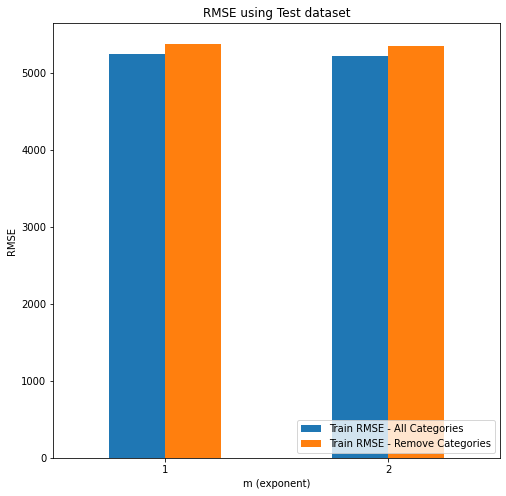

,Train RMSE - All Categories,Train RMSE - Remove Categories
1,5245.880471,5381.493274
2,5217.119733,5355.274255


In [1325]:
sqrt_error_all_train = [sqrt_error_all_train_1, sqrt_error_all_train_2]
sqrt_error_train = [sqrt_error_train_1, sqrt_error_train_2]
index = [1, 2]
sqrt_error_df = pd.DataFrame({'Train RMSE - All Categories' : sqrt_error_all_train, 'Train RMSE - Remove Categories' : sqrt_error_train}, index = index)
ax = sqrt_error_df.plot.bar(rot=0, figsize = (8,8), legend = False)
plt.ylabel('RMSE')
plt.xlabel('m (exponent)')
plt.title('RMSE using Test dataset')
plt.legend(loc = 'lower right')
plt.show()
display(sqrt_error_df)

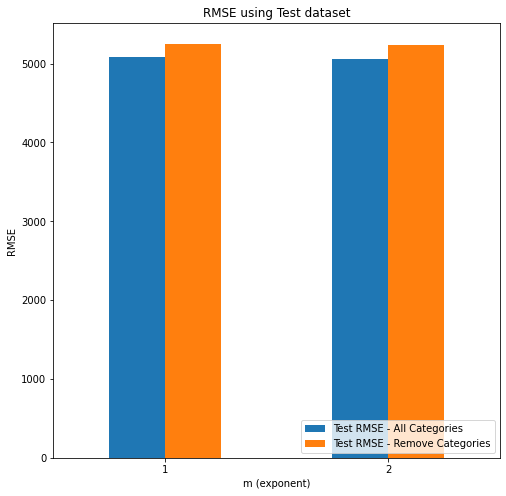

,Test RMSE - All Categories,Test RMSE - Remove Categories
1,5085.037393,5253.531427
2,5058.462002,5231.245213


In [1326]:
sqrt_error_all_test = [sqrt_error_all_test_1, sqrt_error_all_test_2]
sqrt_error_test = [sqrt_error_test_1, sqrt_error_test_2]
index = [1, 2]
sqrt_error_df = pd.DataFrame({'Test RMSE - All Categories' : sqrt_error_all_test, 'Test RMSE - Remove Categories' : sqrt_error_test}, index = index)
ax = sqrt_error_df.plot.bar(rot=0, figsize = (8,8), legend = False)
plt.ylabel('RMSE')
plt.xlabel('m (exponent)')
plt.title('RMSE using Test dataset')
plt.legend(loc = 'lower right')
plt.show()
display(sqrt_error_df)

<h4>Use all categories and m = 2 may be one of the optimal solutions</h4>